![](Rydiqule_Logo_Transparent_300.png)

# Introduction to Rydiqule
**RydIQule**, the Rydberg Interactive Quantum Module, is a python library built to simulate the interaction of Rydberg atoms and light using a semi-classical approach. This notebook will illustrate some of its core functionality, and demonstrate how to use the tool to model simple systems. The intent here is not to demonstrate discoveries in physics, or even simulate useful physics generally. The values provided are deliberately simple integers to make the functions as easy to understand as possible. Thus, the notebook will use cartoonish but nontrivial (from a code perspective) examples to demonstrate how to use the module. Feel free to run the cells of this notebook as-is, but also by all means add and modify cells to get a better feel for how the package works.

This notebook can be downloaded [here](https://github.com/QTC-UMD/rydiqule/blob/main/docs/source/intro_nbs/Introduction_To_Rydiqule.ipynb).

The functionality and principles behind `rydiqule` are detailed much more thoroughly in [the documentation](https://rydiqule.readthedocs.io/). A few places in the docs are worth pointing out:
1. [API Documentation](https://rydiqule.readthedocs.io/page/api/api_index.html) contains detailed information about how the functions of rydiqule behave from a software perspective.
2. [Physics Documentation](https://rydiqule.readthedocs.io/page/writeups/writeups_index.html) contains writeups detailing the physics and math conventions used by rydiqule. There are places where `rydiqule` diverges from the conventions of atomic physicists for numerical or code-related reasons, or makes explicit decisions about conventions that are not universal. It is a very helpful reference when something is not working as you expect.
3. There are example notebooks that can be accesed from the docs homepage which contain  more realistic use cases for rydiqule. 

## Design philosophy
Rydiqule was built with a few core principles in mind:

1. **Rydiqule is simple** - Setting and solving an atomic system can be done with just a handful of lines of code while behaving in an intuitive way.
2. **Rydiqule is fast** - Under the hood, the library makes broad use of fast numpy matrix braodcasting and compiled code in places that would be slowed down by native python. The result is a toolbox that can produce meaningful results in a few minutes or less.
3. **Rydiqule is flexible** - Rydiqule can model a huge variety of semiclassical Rydberg atomic systems with no code modification. For users with more particular modelling needs who wish to extend Rydiqule, the `Sensor` class provides a minimal physical system that can easily be inherited and overloaded for more involved experimental setups.

## Limitations
While we have worked hard to make Rydiqule as good as possible, there are some areas that can cause issues:

1. **Memory** - For systems with many laser parameter values, many levels, doppler averaging in several dimensions, or especially a combination of these, the equations of motion generated by rydiqule simply have to be very large, often requiring more memory than is in a typical laptop or simple desktop. For very large systems, the memory footprint may even outpace a powerful workstation. Rydiqule has built-in functionality to handle some of these cases, but it is far from perfect and will need to be iteratated upon to be as flexible as possible.
2. **Speed** - While huge improvements have been made in the speed of `rydiqule` since its first draft, there are certain situations that  can still cause some slowdowns. For longer simulations, in particular for the poorly-conditioned equations produced with large doppler width, solving can still be slow.
4. **Quantum Back-action** - We treat the optical fields as static, and do not include them explicitly in the semi-classical equations of motion.  Rydiqule does not account for atom-field back-action effects.  This approximation is valid for low optical depth samples, and is known to give valid results for SNR in moderate optical depth samples.  However, for quantitative analysis of quantum noise in high optical depth samples, Rydiqule may not be accurate.
5. **Device Modelling** - Rydiqule is a physics solver, and does not currently have user-friendly support for device-level modelling.

### Imports
Rydiqule is conventionally imported as `rq`. In addition, `numpy` and `matplotlib` are almost always useful to have in notebooks using rydiqule, so we will import them as well. They are dependencies of `rydiqule`, so they should already be installed if you installed rydiqule.

In [2]:
import rydiqule as rq
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---
## 1.  The `Sensor` object
The `Sensor` is the core object of rydiqule. It defines an atomic system, and while you can create and solve a Hamiltonian manually, the `Sensor` takes care of the bookeeping to generate Hamiltonians and solve its associated equations of motion.

Note: Don't think too hard about why it is called a `Sensor`, it is a legacy name that does not necessarily capture its entire functionality.

### 1.1 The quantum state basis of `Sensor`
The base `Sensor` class is constructed with a single required argument, which specifies which states are in the basis. Here we create a 3-level system in the manner `rydiqule` supports: an integer defining the basis size. On its own, a `Sensor` contains no information about atomic structure; it is an abstraction that allows for a high degree of manual configuration.

In [2]:
basis_size = 3
simple_sensor = rq.Sensor(basis_size)

This is the simplest way to define a `Sensor` with a particular number of states (3 in this case). In this case, the basis states will simply be labeled `[0,1,2]`, ($|0\rangle , |1\rangle , |2\rangle$). However, mutiple other ways exist to label the basis states. Rather than an integer (which will implcitly use python's `range()`), we can pass a list of basis state labels directly. These labels can either be strings or tuples. Tuples in particular can be useful for representing quantum numbers, although they can represent anything that you think is useful; they do not invoke any physics in `Sensor`.

In [3]:
string_sensor = rq.Sensor(['g', 'e1', 'e2'])
tuple_sensor = rq.Sensor([(0,0), (1,-1), (1,0), (1,1)])

Once we have created a `Sensor`, we can use the `Sensor.states` attribute to see the states. Note that the ordering of states in a `Sensor` will always be as they are provided in the constructor. 

In [4]:
print(simple_sensor.states)
print(string_sensor.states)
print(tuple_sensor.states)

[0, 1, 2]
['g', 'e1', 'e2']
[(0, 0), (1, -1), (1, 0), (1, 1)]


Specifications of tuples like the one above can become cumbersome, especially to represent large groups of states. For tuples, `rydiqule` also supports "state specifications", in which one of the tuple elements is provided as a list. `rydiqule` will automatically expand such a state into a list as demonstrated below. Note that even when a specification like this is used, it is still necessary to enclose it in list brackets in the constructor. Furthermore, it is often useful to define tuples outside functions, since the number of brackets and parentheses can become cumbersome. This is a safe operation since tuples in python are immutable.

In [5]:
g = (0,0)
e = (1, [-1,0,1])
state_spec_sensor = rq.Sensor([g,e])
print(state_spec_sensor.states)

[(0, 0), (1, -1), (1, 0), (1, 1)]


### 1.2 `Sensor` Data structure: The Graph
Before we proceed to useful physics, it is worth a brief sidebar to discuss how the information about levels and couplings is stored in a `Sensor`. [NetworkX](https://networkx.org/) is a library for storing and analyzing graphs in python that uses dictionaries to store information about nodes and edges. At the core of a `Sensor` is a `networkx` graph. The energy levels in an atomic system are stored as nodes and the couplings between states are stored as edges. Above, when we define a "3-level system", what `rydiqule` has created under the hood is a `networkx` directed graph with 3 nodes and no edges. We can access this graph to view information about it with the `Sensor.couplings` attribute. Let's inspect the `tuple_sensor` we made above and see that the graph nodes are indeed the states we printed above.

In [6]:
print(tuple_sensor.couplings)
print(tuple_sensor.couplings.nodes)

DiGraph with 4 nodes and 0 edges
[(0, 0), (1, -1), (1, 0), (1, 1)]


Indeed the `states` attribute is just a wrapper for `couplings.nodes`. Note that this is provided only as an interface to view the graph, and it shoud **NOT** be modified directly, as doing so may cause `rydiqule` to either `Error` or not work as expected.

### 1.3 Coupling states with simple electromagnetic fields:
While its great to create basis states, there isn't any physics in an atomic system of completely uncoupled basis states. Fortuntely, it is easy to couple states together in `rydiqule` to start moddelling interesing physics. States are coupled together using, at minimum, the following:
1. A 2-element tuple representing the states to be coupled.
2. The rabi_frequency. `rydiqule` treats all frequencies in Mrad/s.
3. The detuning (for couplings to be treated in the rotating frame), or the transition frequency.

#### Notes on detunings and rotating wave transformation  
When we define detunings, the states in a coupling are always defined to go from lower to higher energy. For example, `(1,2)` means state 2 is higher than 1. Any coupling with a defined `detuning` will be treated in a rotating frame, with positive detuning always treated as a blue detuning. For now, we will only consider detunings, but later we will discuss transition frequency specification in the cotext of exactly modelling time-dependant effects.

Here we will demonstrate defining a few different systems, showing different equivalent methods for each.

#### Defining a simple Ladder system
This demonstrates how a minimal ladder system with simple values might be defined in `rydiqule`. Here we use the standard integer basis and the `add_couplings` method.

In [7]:
ladder_sensor = rq.Sensor(3)
laser_01 = {"states": (0,1), "detuning": 1, "rabi_frequency": 3}
laser_12 = {"states": (1,2), "detuning": 2, "rabi_frequency": 5}
ladder_sensor.add_couplings(laser_01, laser_12)

To demonstrate what happens under the hood, let us inspect the `Sensor.coupling` object again, this time looking at the graph edges. We can look at just `edges`, for an overview of which nodes are coupled, or we can use `edges(data=...)` for more thorough representations.

In [8]:
print("Edge Keys: ", ladder_sensor.couplings.edges)
print("Edge Data: ", ladder_sensor.couplings.edges(data=True))
print("Edge Rabi: ", ladder_sensor.couplings.edges(data="rabi_frequency"))


Edge Keys:  [(0, 1), (1, 2)]
Edge Data:  [(0, 1, {'rabi_frequency': 3, 'detuning': 1, 'phase': 0, 'kvec': (0, 0, 0), 'coherent_cc': 1.0, 'label': '(0,1)'}), (1, 2, {'rabi_frequency': 5, 'detuning': 2, 'phase': 0, 'kvec': (0, 0, 0), 'coherent_cc': 1.0, 'label': '(1,2)'})]
Edge Rabi:  [(0, 1, 3), (1, 2, 5)]


As we can see, the options described above are just the minimum; there are more keywords we can use to describe a coupling between two states. More complicated uses will be discussed in detail in other places in this notebook, but here is a brief overview of each optimal argument:
1. `phase` describes the relative phase of a field, and will scale the corresponding off-diagonal terms with an $e^{i\theta}$ phase offset.
2. `kvec ` is a description of a laser's k-vector, and is described by (x,y,z) components. This is relevant when we discuss doppler-broadened calculations later. For now, leaving it at the default will ignore doppler effects.
3. `coherent_cc` is a general abstraction of what is essentially a Clebsch-Gordon coefficient. These will become relevant when we discuss coupling manifolds of states later. The default is 1, and that will effectively ignore the value.
4. `label` is a string shorthand that can reference the coupling in some other contexts. Useful labels might include `"blue"`, `"red"`, `"probe"`, `"pumping"`. This label will enforce nothing with regards to physics, but may be helpful. If it is not supplied, it will default to a string cast of the tuple describing the states, as above.

Any of these values can be defined in the coupling in the exact same manner as "detuning" or "rabi_frequency".

#### Printing `Sensor` Data
Since calling that info above is a little bit tedious, `rydiqule` also supports directly printing a sensor using python's `print()` function, which will summarize basic information about a `Sensor`. We will typically use this method of displaying information about the graph in these notebooks, since it prints in a more readable way.

In [9]:
print(ladder_sensor)

<class 'rydiqule.sensor.Sensor'> object with 3 states and 2 coherent couplings.
States: [0, 1, 2]
Coherent Couplings: 
    (0,1): {rabi_frequency: 3, detuning: 1, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (0,1)}
    (1,2): {rabi_frequency: 5, detuning: 2, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (1,2)}
Decoherent_couplings:
    None
Energy Shifts:
    None


We will discuss Decoherent Couplings and Energy shifts, later, but for now we can see this is a substantially easier way to view information about the `Sensor`

#### Automatic Hamiltonian generation
Once the system is defined, we can see the Hamiltonian matrix. In many ways, this is the core piece of `rydiqule` that makes it useful. You usually will not need to call this explicitly (it will be called internally by a solver, more on that later), but it can be useful to make sure the system is defined as expected.

In [10]:
print(ladder_sensor.get_hamiltonian())

[[ 0. +0.j  1.5+0.j  0. +0.j]
 [ 1.5-0.j -1. +0.j  2.5+0.j]
 [ 0. +0.j  2.5-0.j -3. +0.j]]


Note the detuning sign convention. We have added a positive detuning value to the system. `rydiqule` chooses a rotating frame automatically, and there is no user-configurable option to change it. The roating frame chosen is one in which a detuning of 1 corresponds to an term of -1 on the Hamiltonian diagonal.

#### Defining a simple Vee scheme
We can do something similar, but with a different arrangement of couplings, and using explicit strings to define the basis. We can also pass fields in the constructor if we like.

In [2]:
basis = ["g", "e1", "e2"]
laser_01 = {"states": ("g","e1"), "detuning": 1, "rabi_frequency": 3, "label":"red"}
laser_02 = {"states": ("g","e2"), "detuning": 2, "rabi_frequency": 5, "label":"blue"}
sensor_v = rq.Sensor(basis, laser_01, laser_02)
print(sensor_v.couplings.edges(data="label"))
print(sensor_v.get_hamiltonian())

[('g', 'e1', 'red'), ('g', 'e2', 'blue')]
[[ 0. +0.j  1.5+0.j  2.5+0.j]
 [ 1.5-0.j -1. +0.j  0. +0.j]
 [ 2.5-0.j  0. +0.j -2. +0.j]]


#### Defining a simple Lambda scheme
Here is another system, this time a lambda scheme. Here we demonstrate another way to add couplings using the `add_coupling` function. This function behaves equivalently to `add_couplings`, and which you choose is up to preference.
As one final way of defing our basis, let's use tuples here. This can be a little more involved, but occasionally useful in large sytems. As discussed above, we will alias the states so couplings don't start getting clunky to define. We also show the `expand_statespec` function to turn the `e` variable into a list of all possible values.

In [3]:
g = (0,0)
e = (1, [-1,0,1])
print("e states: ", rq.expand_statespec(e)) #just creates a list, no physics is done here
[e1, e2, e3] = rq.expand_statespec(e) #unpack the list for easy use later.

sensor_lambda = rq.Sensor([g, e]) #note that ryqiqule will automatically unpack e into a list

sensor_lambda.add_coupling((g, e1), rabi_frequency=1, detuning=1)
sensor_lambda.add_coupling((e1,e2), rabi_frequency=2, detuning=2)
sensor_lambda.add_coupling((e3,e2), rabi_frequency=3, detuning=3) #tuples always go from low to high energy by convention

print(sensor_lambda)
print(sensor_lambda.get_hamiltonian())

e states:  [(1, -1), (1, 0), (1, 1)]
<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [(0, 0), (1, -1), (1, 0), (1, 1)]
Coherent Couplings: 
    ((0, 0),(1, -1)): {rabi_frequency: 1, detuning: 1, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: ((0, 0),(1, -1))}
    ((1, -1),(1, 0)): {rabi_frequency: 2, detuning: 2, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: ((1, -1),(1, 0))}
    ((1, 1),(1, 0)): {rabi_frequency: 3, detuning: 3, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: ((1, 1),(1, 0))}
Decoherent_couplings:
    None
Energy Shifts:
    None
[[ 0. +0.j  0.5+0.j  0. +0.j  0. +0.j]
 [ 0.5-0.j -1. +0.j  1. +0.j  0. +0.j]
 [ 0. +0.j  1. -0.j -3. +0.j  1.5-0.j]
 [ 0. +0.j  0. +0.j  1.5+0.j  0. +0.j]]


#### Systems that are not fully coupled
We can also define a system in which not all states are connected explicitly by couplings. This allows us to solve systems which, for example, have states coupled only by decoherence. This exact use case will be demonstrated later, but we can set up the system and show the hamiltonian here. 

The hamiltonaian works by treating an uncoupled states as a "second ground state", and calculates digonal hamiltonian elements from there. We show a 4-level system in which state 4 is coupled to state 5 via a steady state rf transition, but to no other states. It should be noted that calling an rf transition does not change the way the system is solved here.

Looking at the hamiltonian, we can see that the 4th term along the diagonal is 0, and the 5th term counts from there.

In [4]:
sensor_uncoupled = rq.Sensor(5)
laser_01 = {"states": (0,1), "detuning": 1, "rabi_frequency": 3}
laser_12 = {"states": (1,2), "detuning": 2, "rabi_frequency": 5}
rf = {"states": (3,4), "detuning": 8, "rabi_frequency": 1}
sensor_uncoupled.add_couplings(laser_01, laser_12, rf)

print(sensor_uncoupled.get_hamiltonian())

[[ 0. +0.j  1.5+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 1.5-0.j -1. +0.j  2.5+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  2.5-0.j -3. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0.5+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0.5-0.j -8. +0.j]]


In some more complicated cases, we may want a more concrete visual reassurance that everything is defined correctly. `rydiqule` makes use of the `leveldiagram` library (which uses matplotlib as a backend) to help draw visual representations of a `Sensor`. In the drawing below, we can see that the diagram indeed shows that states 2 and 3 are not coupled. Keep in mind that these drawings have limitations. Especially in very large, highly-coupled systems, the output can get quite cramped, although it is still a helpful sanity check.

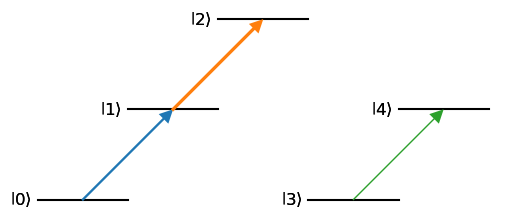

In [13]:
rq.draw_diagram(sensor_uncoupled)

### 1.5 Coupling state manifolds
So far we have shown the basics of adding couplings. There is one final important detail regard coherent couplings, and that is the use of `add_coupling` to couple entire groups of states with a single call. To do so, we define a `statespec` as in the Lambda example above. Let's construct a similar `Sensor`. 

In [5]:
g = (0,0)
e = (1, [-1,0,1])
[e1, e2, e3] = rq.expand_statespec(e)

sensor_man = rq.Sensor([g, e])
print(sensor_man.couplings.nodes)

[(0, 0), (1, -1), (1, 0), (1, 1)]


Once we have the `Sensor` defined, we can actually couple the ground state to every excited state with a single call by simply treating `e` as one state. Note that in this case, `"label"` becomes a required argument. Defining in this way will automagically loop over every state in the `e` "manifold" and add a coupling between `g` and each one. Let's add the coupling and see what edges get added. 

In [8]:
sensor_man.add_coupling((g,e), rabi_frequency=2, detuning=1, label="probe")
print(sensor_man)

<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [(0, 0), (1, -1), (1, 0), (1, 1)]
Coherent Couplings: 
    ((0, 0),(1, -1)): {rabi_frequency: 2, detuning: 1, phase: 0, kvec: (0, 0, 0), label: probe_0, coherent_cc: 1.0}
    ((0, 0),(1, 0)): {rabi_frequency: 2, detuning: 1, phase: 0, kvec: (0, 0, 0), label: probe_1, coherent_cc: 1.0}
    ((0, 0),(1, 1)): {rabi_frequency: 2, detuning: 1, phase: 0, kvec: (0, 0, 0), label: probe_2, coherent_cc: 1.0}
Decoherent_couplings:
    None
Energy Shifts:
    None


Note that as-is, these 3 states are degenerate. There are a few modifications we can make.
1. We can use the `add_energy_shifts` function to break the degeneracy. This will have the effect of adding diagonal terms to the hamiltonian. 
2. Now the `coherent_cc` we saw above becomes relevant. We can add a dictionary that represents a "weighting" to each individual coupling in the group, and pass it under the "coupling_coefficients" keyword. This will not change the rabi_frequency directly, but it will apply a prefactor to the rabi_frequency when generating the hamiltonian.

We will re-make the sensor, and make some sensible choices to demonstate `energy_shifts` and `coupling_coefficients`, in this case using dictionaries. Take a moment to understand this part: it is crucial to understand how to do more advanced calculations. Here we also see where the `Energy Shifts` section of the printout comes in.

In [9]:
g = (0,0)
e = (1, [-1,0,1])
[e1, e2, e3] = rq.expand_statespec(e)

#defing coupling coefficients and energy shifts
cc = {
    (g,e1): 0.25,
    (g,e2): 0.5,
    (g,e3): 0.25
}
e_shifts = {e1:-0.1, e3: 0.1} 
.
sensor_man = rq.Sensor([g, e])
sensor_man.add_energy_shifts(e_shifts)
sensor_man.add_coupling((g,e), detuning=1, rabi_frequency=2, coupling_coefficients=cc, label="foo")

print(sensor_man)

<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [(0, 0), (1, -1), (1, 0), (1, 1)]
Coherent Couplings: 
    ((0, 0),(1, -1)): {rabi_frequency: 2, detuning: 1, phase: 0, kvec: (0, 0, 0), label: foo_0, coherent_cc: 0.25}
    ((0, 0),(1, 0)): {rabi_frequency: 2, detuning: 1, phase: 0, kvec: (0, 0, 0), label: foo_1, coherent_cc: 0.5}
    ((0, 0),(1, 1)): {rabi_frequency: 2, detuning: 1, phase: 0, kvec: (0, 0, 0), label: foo_2, coherent_cc: 0.25}
Decoherent_couplings:
Energy Shifts:
    (1, -1): -0.1
    (1, 1): 0.1


One thing to note here is that `e_shift` actually adds an edge from a node to itself. This isn't a crucial detail, but can be helpful to know if you need to debug a complicated system. Now that everything on the graph makes sense, lets see what the Hamiltonian does:

In [18]:
print(sensor_man.get_hamiltonian())

[[ 0.  +0.j  0.25+0.j  0.5 +0.j  0.25+0.j]
 [ 0.25-0.j -1.1 +0.j  0.  +0.j  0.  +0.j]
 [ 0.5 -0.j  0.  +0.j -1.  +0.j  0.  +0.j]
 [ 0.25-0.j  0.  +0.j  0.  +0.j -0.9 +0.j]]


We have broken the energy level degeneracy with some terms added along the diagonal, and given a stronger coupling to the `(1,0)` state.

### 1.6 Decoherent transitions
There is one more important aspect of defining the `Sensor` graph that we have not discussed (which we can actually see as absent in the`Sensor` printout), and that is decoherent couplings. Decays of this sort are added with the `add_decoherence` function, which works very similarly to the `add_coupling` function. State manifolds and coupling coefficients work in an identical manner. Here we can copy the `Sensor` we used above, and add a decoherence in coupling the excited manifold to the ground state. The only minor difference is that decoherences do not use keyword arguments, but added with a single required argument defining the decay rate, again in Mrad/sec.

In [11]:
g = (0,0)
e = (1, [-1,0,1])
[e1, e2, e3] = rq.expand_statespec(e)

#defing coupling coefficients and energy shifts
cc = {
    (g,e1): 0.25,
    (g,e2): 0.5,
    (g,e3): 0.25
}
e_shifts = {e1:-0.1, e3: 0.1} 

sensor_man = rq.Sensor([g, e])
sensor_man.add_energy_shifts(e_shifts)
sensor_man.add_coupling((g,e), detuning=1, rabi_frequency=2, coupling_coefficients=cc, label="foo")
sensor_man.add_decoherence((e,g), 0.1, label="bar")
print(sensor_man.get_hamiltonian())

[[ 0.  +0.j  0.25+0.j  0.5 +0.j  0.25+0.j]
 [ 0.25-0.j -1.1 +0.j  0.  +0.j  0.  +0.j]
 [ 0.5 -0.j  0.  +0.j -1.  +0.j  0.  +0.j]
 [ 0.25-0.j  0.  +0.j  0.  +0.j -0.9 +0.j]]


Obviously, the hamiltonian will be the same, but we can inspect what got added to the graph again using `Sensor.couplings.edges`. We will then get the decoherence matrix with `decoherence_matrix`, similarly to `get_hamiltonian()`. We will discuss how the decoherence matrix is used in more detail below when we discuss solving.

In [20]:
print("Graph Edges: ")
print(sensor_man.couplings.edges(data=True))
print("Decoherence matrix: ")
print(sensor_man.decoherence_matrix())

Graph Edges: 
[((0, 0), (1, -1), {'rabi_frequency': 2, 'detuning': 1, 'phase': 0, 'kvec': (0, 0, 0), 'label': '((0,0),(1,-1))', 'coherent_cc': 0.25}), ((0, 0), (1, 0), {'rabi_frequency': 2, 'detuning': 1, 'phase': 0, 'kvec': (0, 0, 0), 'label': '((0,0),(1,0))', 'coherent_cc': 0.5}), ((0, 0), (1, 1), {'rabi_frequency': 2, 'detuning': 1, 'phase': 0, 'kvec': (0, 0, 0), 'label': '((0,0),(1,1))', 'coherent_cc': 0.25}), ((1, -1), (1, -1), {'e_shift': -0.1, 'label': '(1, -1)'}), ((1, -1), (0, 0), {'gamma_bar': 0.1, 'label': '((1,-1),(0,0))'}), ((1, 0), (0, 0), {'gamma_bar': 0.1, 'label': '((1,0),(0,0))'}), ((1, 1), (1, 1), {'e_shift': 0.1, 'label': '(1, 1)'}), ((1, 1), (0, 0), {'gamma_bar': 0.1, 'label': '((1,1),(0,0))'})]
Decoherence matrix: 
[[0.  0.  0.  0. ]
 [0.1 0.  0.  0. ]
 [0.1 0.  0.  0. ]
 [0.1 0.  0.  0. ]]


The edges are getting quite busy, but we will spot `"gamma_bar"` attributes on the expected graph edges. This is the convention used by `rydiqule`: when `add_decoherence` or a related function is called, and `label` is provided, the associated key on the graph will be `"gamma_" + label`. If no `label` is provided, simply `"gamma"` will be used for the key. When `decoherence_matrix` is called, every attribute on each edge that starts with `"gamma"` will be added together and placed on the appropriate term of a decoherence matrix.  

There are a few more functions to be aware of when it comes to definining decoherence rates:
1. `add_transit_broadening` will add a decoherence from each state to the ground state (by default) or to a particular set of ground states. This function is designed to account for atoms which move out of a laser and are replaced by atoms in their ground state(s). Fractional transit broadenings are specified with the `repop` keyword arg.
2. `add_self_broadening` will add a decoherence from a state to itself to account for a atoms losing coherence; remaining in the same state.
3. `set_gamma_matrix` takes a square numpy array as an argument, then applies an appropriate `"gamma"` value to each graph edge.

We have printed attributes directly from the graph for the purposes of demonstrating what is happening under the hood. Unless you need to inspect attributes of the graph directly, a simple `print` statement will give us a more readable output.

In [13]:
print(sensor_man)

<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [(0, 0), (1, -1), (1, 0), (1, 1)]
Coherent Couplings: 
    ((0, 0),(1, -1)): {rabi_frequency: 2, detuning: 1, phase: 0, kvec: (0, 0, 0), label: foo_0, coherent_cc: 0.25}
    ((0, 0),(1, 0)): {rabi_frequency: 2, detuning: 1, phase: 0, kvec: (0, 0, 0), label: foo_1, coherent_cc: 0.5}
    ((0, 0),(1, 1)): {rabi_frequency: 2, detuning: 1, phase: 0, kvec: (0, 0, 0), label: foo_2, coherent_cc: 0.25}
Decoherent_couplings:
    ((1, -1),(0, 0)): {gamma_bar: 0.1}
    ((1, 0),(0, 0)): {gamma_bar: 0.1}
    ((1, 1),(0, 0)): {gamma_bar: 0.1}
Energy Shifts:
    (1, -1): -0.1
    (1, 1): 0.1


---
## 2. Solving a `Sensor` in the steady-state case
So far we have just created sensor objects and shown their corresponding Hamiltonians. The most important functionality of `rydiqule`, however, is solving their associated equations of motion automatically. Here we will demonstrate some of the ways to solve a simple system using `rydiqule`.

### 2.1 What is `rydiqule` actually solving?
In the section title, we simply refer to "solving a sensor". When we discuss solving a system, what we mean is that we are solving the Lindblad Master Equation associated with the system described by our `Sensor`: 
$$ \dot{\rho} = -i[\hat{H}, \rho] - \mathcal{L} $$
where $\mathcal{L}$ is the Lindblad operator that accounts for non-unitary dephasing effects.

When `rydiqule` solves in the steady state, what is ultimately produced is the steady-state solution of that differential equation. `rydiqule` is capable of inferring the relevant matrix quantities from the graph defined by a `Sensor`, as we have seen above.

### 2.2 Basic Solving in the steady state
If all we need is steady state behavior of a particular system, it is straightforward and quick in `rydiqule`. By wrapping a simple matrix differential equation solver, `rydiqule` can quickly get the steady state frequencies of each element of the density matrix $\rho$ of the system. We start by re-defining the same ladder system we had at the beginning of the notebook.

In [15]:
basis_size = 3
sensor_demo = rq.Sensor(basis_size)

laser_01 = {"states": (0,1), "detuning": 1, "rabi_frequency": 3}
laser_12 = {"states": (1,2), "detuning": 2, "rabi_frequency": 5}
sensor_demo.add_couplings(laser_01, laser_12)

gamma = np.zeros((basis_size, basis_size))
gamma[1:,0] = 0.1
print(gamma)
sensor_demo.set_gamma_matrix(gamma)

[[0.  0.  0. ]
 [0.1 0.  0. ]
 [0.1 0.  0. ]]


Now, instead of showing the Hamiltonian, we can just call the `rydiqule.solve_steady_state()` function on `sensor` and get the result.

In [16]:
solution_demo = rq.solve_steady_state(sensor_demo)
print(solution_demo)

### 2.3 The `Solution` object
As you can see, the solution itself is not an array, but an object containing some extra information. When `rydiqule` solves a system, it saves the solution, but also many other things relevant to the solve (including the graph itself), so that relevant quantities about the original `Sensor` and solve can be computed and reproduced. Since the above output is a bit cluttered, let's contain outselves to just the important quanties for now. First, `couplings` is just a copy of the `Sensor.couplings` graph discussed above for the `Sensor` on which `solve_steady_state` was called. Next, `rho` is the density matrix solution of the system, but there is a catch.

In [19]:
print(f"Couplings: {solution_demo.couplings}")
print(f"rho: {solution_demo.rho}")
print(len(solution_demo.rho))

Couplings: DiGraph with 3 nodes and 4 edges
rho: [-0.09225689 -0.1820376   0.01617957  0.27218216  0.21003648  0.00831697
  0.0042641   0.21320497]
8


#### Adjustments to the equations
So why does the solution have 8 elements? Why is it real? Why is it 1-dimensional? After all, it represents a density matrix, which should have $n^2$ complex-valued elements ($3^2=9$ in this case), ideally arranged in square.

For numerical stability, `rydiqule` removes the ground state population equations, so the $\rho_{00}$ term is omitted from the solution (typically $\rho_{00} >> \rho_{ij}$ for $ij \neq 00$, which is the source of the numerical problems). If needed, it can be inferred as $\rho_{00} = 1 - \sum_{i=1}^{n} \rho_{ii}$. Furthermore, rydiqule transforms the basis so that all values are real. Rather than an $n\times n$ Hermitian matrix, `rydiqule` parameterizes the density matrix $\rho$ as $n\times n$ real values before removing the ground state, for a total of $n^2-1$ values. For more details, refer to the [documentation](https://rydiqule.readthedocs.io/page/writeups/eom_notes.html#removing-the-ground-state). We really do wish these modifications were not necessary, but keeping the ground state population and complex density matrix elememts resulted in unphysical soulutions during development.

So how do we know (ideally quickly) which element of the solution corresponds to which density matrix element? The `Solution`  contains an attribute called `dm_basis` which does exactly this, containing a list of strings showing the info we want. Since the density matrix is hermitian and trace 1, this array does indeed contain all of the information of the density matrix.  Note that `dm_basis` does not include $\rho_{00}$ since the ground state is removed by the solver.

We choose to keep this basis in rydiqule since it is more transparent to what `rydiqule` does under the hood, and is used in further calculations. 

In [24]:
print(solution_demo.dm_basis)

['01_real' '02_real' '01_imag' '11_real' '12_real' '02_imag' '12_imag'
 '22_real']


If we quickly want a particular full complex density matrix element, the `rho_ij` function does precisely that:

In [20]:
print(f"rho_10 = {solution_demo.rho_ij(1,0)}")

rho_10 = (-0.09225688789212272+0.016179570807727885j)


There are a few other functions to be aware of in a `Solution` object. Some commonly-computed quantities that might be derived from a density matrix solution. Before we discuss them, it is worth a brief aside on the `Solution.probe_tuple` quantity. It is a quantity that is derived from the `Sensor` that is the transition over which, by default, observable calculations will be made. So in the absence of any other information, when observable values are computed, they are computed for the density matrix elements that are defined by the `probe_tuple`. The `probe_tuple` is set by the first coupling that is added with the `add_coupling` function in `Sensor` (equivalently, the first dictionary passed to `add_couplings`). While this quantity can be set manually, it is usually better practice to define whatever the probing transition (usually the laser you will be measuring) first, and not change `probe_tuple` manually when it can be avoided. To demonstrate this, we can see what `probe_tuple` is in both the `Sensor` and `Solution`.

In [26]:
print(sensor_demo.probe_tuple)
print(solution_demo.probe_tuple)

(0, 1)
(0, 1)


As expected, this is the the first coupling added to the system. Below is a (very) brief example to show the `probe_tuple` being added.

In [27]:
sensor_probe = rq.Sensor(3)
print(sensor_probe.probe_tuple)
sensor_probe.add_coupling((0,2), rabi_frequency=1, detuning=0)
print(sensor_probe.probe_tuple)
sensor_probe.add_coupling((1,2), rabi_frequency=1, detuning=0)
print(sensor_probe.probe_tuple)

None
(0, 2)
(0, 2)


With the `probe_tuple` cleared up, we can explore a few of the other functions in a `Solution`. 

1. `get_observable(A)` is a function which, given an observable matrix $A$, uses the density matrix definition of the expectation value of $A$, $\langle A\rangle = tr(\rho A)$.
2. `coupling_coefficent_matrix(<coupling>)` returns a matrix of all coupling coefficients on a particular transition defined by coupling. We discussed the coupling cofficients above in the context of relative coupling strength. In this way they can be thought of as a unitless analogue of the dipole moment.
3. Given these two quantities, you may be developing an idea that it my be useful to pass the output of `coupling_coefficient_matrix` to `get_observable` and use that to compute susceptibility. It's such a good idea, `rydiqule` went ahead and implemented that function in `Solution.get_susceptibility()`. The value will be computed from a handful of quantities built in to `Solution`, and more details about its calculation can be found in the [docs](https://rydiqule.readthedocs.io/page/api/_autosummary/rydiqule.sensor_solution.Solution.html#rydiqule.sensor_solution.Solution.get_susceptibility). Note that this calculation will require setting the `kappa` and `probe_freq` attributes in a `Sensor` before it is solved (or, technically, in the solution itself but this is not the recommended use). Again, see [the docs](https://rydiqule.readthedocs.io/page/api/_autosummary/rydiqule.sensor.Sensor.html#rydiqule.sensor.Sensor.set_experiment_values) for further details. Note that this function will implicitly only get the observable over the `probe_tuple` transition.

We will demonstrate getting the susceptibility with `get_susceptibility()` below, although keep in mind these are *very* cartoonish and unphysical values

In [28]:
sensor_demo.set_experiment_values(kappa=1, probe_freq=1000)
solution_demo = rq.solve_steady_state(sensor_demo)
print(solution_demo.get_susceptibility())

(-0.03687722558481321+0.006467351069111717j)


### 2.4 Stacking: Solving for multiple values of a parameter
Getting a single result is nice, but really just a single data point. One of the simplest types of experiments you might want to simulate is to scan, for example, over a range of detuning values and see the behavior of the system at each value. One of `rydiqule`'s greatest strength is its handling of simulations like this. Suppose we wanted to sweep our probe laser detuning between -10 MHz and 10 MHz. Without `rydiqule` we might write an explicit loop over a set of values, modifying and solving the system at each iteration, and storing the results in a new list. In python especially, this sort of approach has a high computational overhead. 

With `rydiqule`, we can set up the system similarly to above, this time as a 4-level system. However, this time, instead of using a single `float` value for a coupling parameter, we will define the $0\leftrightarrow 1$ coupling detunuing value as a 1-dimensional numpy array constructed with the `linspace` function. after this, `rydiqule` will handle the rest.

In [36]:
basis_size = 4
sensor_sweep = rq.Sensor(basis_size)

detunings = 2*np.pi*np.linspace(-10,10,201) #201 values between -10 and 10 MHz
probe = {"states":(0,1), "detuning": detunings, "rabi_frequency": 3}
coupling = {"states":(1,2), "detuning": 0, "rabi_frequency": 5}
rf = {"states":(2,3), "detuning": 0, "rabi_frequency":7}

sensor_sweep.add_couplings(probe, coupling, rf)

sensor_sweep.add_decoherence((1,0), 0.1)
sensor_sweep.add_decoherence((2,1), 0.1)
sensor_sweep.add_decoherence((3,0), 0.1)

Before we continue further, let us examine the printout of the `Sensor`, and the shape of the hamiltonian produced by `get_hamiltonian`:

In [37]:
print(sensor_sweep)
print(sensor_sweep.get_hamiltonian().shape)

<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [0, 1, 2, 3]
Coherent Couplings: 
    (0,1): {rabi_frequency: 3, detuning: <parameter with 201 values>, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (0,1)}
    (1,2): {rabi_frequency: 5, detuning: 0, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (1,2)}
    (2,3): {rabi_frequency: 7, detuning: 0, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (2,3)}
Decoherent_couplings:
    (1,0): {gamma: 0.1}
    (2,1): {gamma: 0.1}
    (3,0): {gamma: 0.1}
Energy Shifts:
    None
(201, 4, 4)


Here we see the familiar $4\times 4$ hamiltonian, but with an additional dimension of size 201, exaclty the size of our detuning array. What `rydiqule` has done behind the scenes is generate a $4\times 4$ Hamiltonian matrix for every detuning value in the array and place them all into a single `np.ndarray`, enabling the use of fast broadcasted numpy functions. `rydiqule` calls this "stacking", and it is the key behind `rydiqule`'s impressive python performace for complicated experiments. Most (although not all) parameters of a `Sensor` can be scanned in this way. The complete list of scannable parameters is:
1. `detuning`
2. `rabi_frequency`
3. `phase`
4. `e_shift`
5. All decoherences

An important note about `rydiqule`'s internal functions is that they are completely agnostic to what each axis of a stack represents, when run through the internal functions, all it needs to know is that something is a stack of hamiltonians. Equations, or density matrices, and the fuctions that use them are performed identically. This will be an important detail in later sections.

From here, we solve exactly as before. Rydiqule will automagically solve the system for every detuning value (very quickly). We also show the utility function `get_rho_ij()` which extracts $\rho_{ij}$ from the density matrix $\rho$ of any solution (regardless of how many dimensions it is). We use it to get $\rho_{01}$.

In [38]:
solution = rq.solve_steady_state(sensor_sweep)
print(f"Solution shape: {solution.rho.shape}")
absorption = solution.coupling_coefficient_observable().imag
print(f"Absorption_shape: {absorption.shape}")

Solution shape: (201, 15)
Absorption_shape: (201,)


We can see that there is a 15-element solution for each one of the detuning values. After we get the absorption using `get_rho_ij()`, we can see that we are left with a single array with 201 elements, corresponding to to the absorption at each value of detuning. Still, that was pretty fast for solving 200 equations. The function doesn't do anything special, it just is a quick way to get common info you might want out of a solution. We can now do a quick-and-dirty plot to see what it looks like:

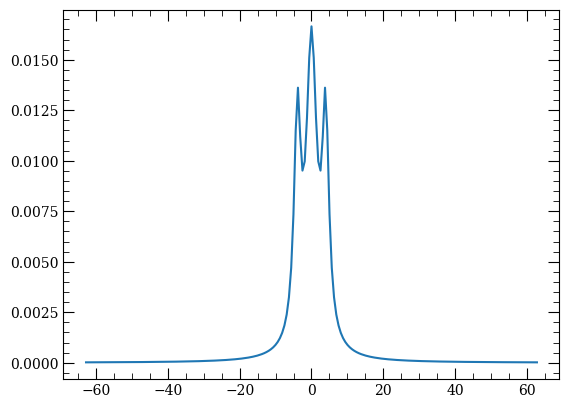

In [41]:
plt.plot(detunings, absorption)
plt.show()

### 2.5 Solving for multiple values of multiple parameters
If you like the simplicity of scanning an single laser detuning in `rydiqule`, you will be even more excited to learn that rydiqule can handle scans over multple different parameters simulataneously. We will set up the sensor as before, with a couple of changes. We will now also scan the dephasing rate and show how the absorption changes.

In [42]:
basis_size = 4
sensor_sweep_2 = rq.Sensor(basis_size)

detunings = 2*np.pi*np.linspace(-10, 10, 201) #201 values between -10 and 10 MHz
probe = {"states":(0,1), "detuning": detunings, "rabi_frequency": 3, "label":"probe"}
coupling = {"states":(1,2), "detuning": 0, "rabi_frequency": 5, "label": "coupling"}
rf = {"states":(2,3), "detuning": 0, "rabi_frequency":7, "label": "rf"}

sensor_sweep_2.add_couplings(probe, coupling, rf)

gamma10 = np.linspace(0.1, 1.0, 10)
sensor_sweep_2.add_decoherence((1,0), gamma10)
sensor_sweep_2.add_decoherence((2,1), 0.1)
sensor_sweep_2.add_decoherence((3,0), 0.1)

print(sensor_sweep_2)

<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [0, 1, 2, 3]
Coherent Couplings: 
    (0,1): {rabi_frequency: 3, detuning: <parameter with 201 values>, phase: 0, kvec: (0, 0, 0), label: probe, coherent_cc: 1.0}
    (1,2): {rabi_frequency: 5, detuning: 0, phase: 0, kvec: (0, 0, 0), label: coupling, coherent_cc: 1.0}
    (2,3): {rabi_frequency: 7, detuning: 0, phase: 0, kvec: (0, 0, 0), label: rf, coherent_cc: 1.0}
Decoherent_couplings:
    (1,0): {gamma: <parameter with 10 values>}
    (2,1): {gamma: 0.1}
    (3,0): {gamma: 0.1}
Energy Shifts:
    None


Once again, no extra steps are required, just call `solve_steady_state()` as normal, and look at the shape of the solution and the absorption and rydiqule will quickly find the solution for every combination of those 2 parameters.

In [43]:
solution_2 = rq.solve_steady_state(sensor_sweep_2)
print(f"Solution shape: {solution_2.rho.shape}")
absorption_2 = solution_2.coupling_coefficient_observable().imag
print(f"Absorption_shape: {absorption_2.shape}")

Solution shape: (201, 10, 15)
Absorption_shape: (201, 10)


How do we know which axis corresponds to the probe detuning and which is the coupling detuning? It is obvious in this case since they are different lengths, but this will not always be the case (for example in cases where two lasers are scanned over the same number of values). `Sensor` and `Solution` both have attributes called `axis_labels` which do just that, and this is where labeling our couplings comes in handy (It is a method of `Sensor`and an attribute of `Solution` for reasons that are not important here). Note that if couplings are not labeled, the axes will default to being labeled by the states they couple. For example `["(0,1)_detuning", (1,2)_detuning"]`, in this case, the output of `axis_labels` is what we would expect based on the solution shape we printed above. Notice that since the detuning scanned was on the laser we labelled `"probe"`, that label is reflected on the axis.

In the case of a `Solution`, the axis of the density matrix is included, but this is not the case in `Sensor`, since there is no associated density matrix until it is solved.

In [35]:
print(sensor_sweep_2.axis_labels())
print(solution_2.axis_labels)

['probe_detuning', '(1,0)_gamma']
['probe_detuning', '(1,0)_gamma', 'density_matrix']


So the first axis corresponds to the probe laser detuning, and the second axis corresponds to $\Gamma_{1,0}$. Now calling a function like `np.argmin()` or `np.argmax()` could quickly be used to optimize some value over a large parameter space. `rydiqule` lets us add as many parameters as you like as a list, detunings, rabi frequencies, or dephasings. It's handy, but beware that the memory footprint can quickly balloon out of control when generating equations of motion if you get too ambitious, increasing by a factor of $n$ when you add an axis with $n$ elements, especially given that many values used in internal calculations are 128-bit complex arrays. 

Currently, `rydiqule` has internal functions to spot this before it happens and break it into more manageable chunks if it can, but it is certainly possible to make a system which even it cannot handle. If the solution does not fit in memory, no amount of splitting up the equations will allow the system to be solved, and you should reconsider the size of your parameter space. Even in the above example, `rydiqule` is solving $201\times 10 \geq 2,000$ equations simultaneously (which is still pretty good). In cases where the parameter space would become intractably large, it is generally good practice to optimise over specific subsets of parameters at a time, or use a coarser mesh to identify a smaller region of interest.

We can plot these probe sweeps at the same time fairly simply.

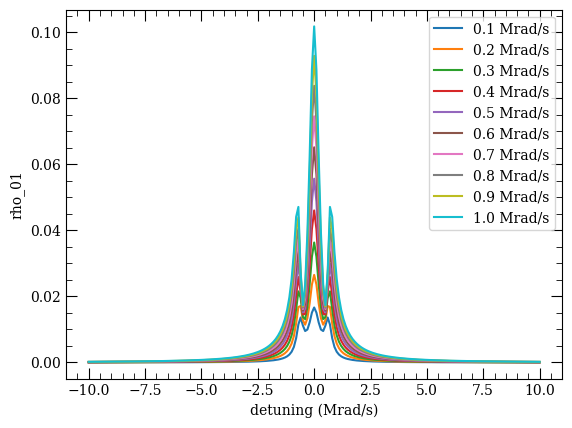

In [58]:
fig, ax = plt.subplots(1)

for i in range(absorption_2.shape[1]):
    ax.plot(detunings/2/np.pi, absorption_2[:,i], label=f'{gamma10[i]:.1f} Mrad/s')

ax.set_xlabel("detuning (Mrad/s)")
ax.set_ylabel("rho_01")

ax.legend();
fig

### 2.6 Parameter zipping

It is not uncommon in atomic physics experiments for 2 different atomic transitions (even just among sublevels) to originate from the same laser. In this case, it is often desirable to run simulations where a value of a parameter in one transition (say the laser power/rabi frequency) maps 1-to-1 to a value in a different transition. At the very least, ensuring that these values are always run together will reduce the number of calculations that need to be done substantially by elimnating unphysical simulations. 

#### Zipping Basics
To handle this case, `Sensor` has a function called `zip_parameters`. We call it a zip because it can be thought about in the same way that python's native `zip()` works for iterators. A zip is defined with a dictionary keyed with coupling labels (including the automatically-generated ones like `"(1,2)"`). `zip_parameters` takes this dictionary as an argument, then places all those values on the same axis in the hamiltonian and equation stack. We demonstrate it below: 

In [60]:
sensor_zip = rq.Sensor(3)
det = np.linspace(-5,5,101)
f1 = {"states": (0,1), "rabi_frequency": 1, "detuning": det, "label":"laser"}
f2 = {"states": (1,2), "rabi_frequency": 1, "detuning": 2*det}
sensor_zip.add_couplings(f1, f2)
print(f"shape before zip: {sensor_zip.get_hamiltonian().shape}")
sensor_zip.zip_parameters({"laser":"detuning", "(1,2)":"detuning"}, zip_label="foo")
print(f"shape after zip: {sensor_zip.get_hamiltonian().shape}")

shape before zip: (101, 101, 3, 3)
shape after zip: (101, 3, 3)


We labelled the zip as `"foo"`, and this is what will be shown on the output of `"axis_labels"`. Had we not provided a label, the one created would be all the couplings joined with underscores. This can be cumbersome-looking, so it generally good practice to label your zips, although not strictly mandatory.

In [65]:
sensor_zip.add_transit_broadening(0.1)
sol = rq.solve_steady_state(sensor_zip)
print(sol.axis_labels)

['foo', 'density_matrix']


Now all the parameters we zipped should line up on their shared axis. As an example, if we inspect Hamiltonian 0, it should correspond to a detuning of -5 (the first detuning value) on the first coupling and -10 (the first detuning value) on the second:

In [67]:
print(sensor_zip.get_hamiltonian()[0])

[[ 0. +0.j  0.5+0.j  0. +0.j]
 [ 0.5-0.j  5. +0.j  0.5+0.j]
 [ 0. +0.j  0.5-0.j 15. +0.j]]


It is worth noting that `zip_parameters` does not change anything on the graph itsself, it just adds the labels to a list which is an internal attribute. The actual zipping is done at hamiltonian/decoherence matrix generation time. 

#### Automatic Zipping
When couplings are defined between manifolds of states as shown above (thus producing more than 1 graph edge) any array-like parameters will be zipped automatically. So no additional steps need to be taken, and the shape of the Hamiltonian will be correct. Here, we see that all the detunings are included as arrays on separate edges, but they share an axis on the hamiltonian automatically.

In [3]:
g = (0,0)
e = (1, [-1,0,1])
[e1, e2, e3] = rq.expand_statespec(e)

#defing coupling coefficients and energy shifts
cc = {
    (g,e1): 0.25,
    (g,e2): 0.5,
    (g,e3): 0.25
}
e_shifts = {e1:-0.1, e3: 0.1}

det = np.linspace(-1,1,11) #short array for readable printout

sensor_man_zip = rq.Sensor([g,e])
sensor_man_zip.add_energy_shifts(e_shifts)
sensor_man_zip.add_coupling((g,e), rabi_frequency=2, detuning=det, coupling_coefficients=cc, label="laser")

print(sensor_man_zip)
    
print(f"Hamiltonian Shape :{sensor_man_zip.get_hamiltonian().shape}")
print(sensor_man_zip.axis_labels())

glorp []
<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [(0, 0), (1, -1), (1, 0), (1, 1)]
Coherent Couplings: 
    ((0, 0),(1, -1)): {rabi_frequency: 2, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser_0, coherent_cc: 0.25, laser_detuning: detuning}
    ((0, 0),(1, 0)): {rabi_frequency: 2, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser_1, coherent_cc: 0.5, laser_detuning: detuning}
    ((0, 0),(1, 1)): {rabi_frequency: 2, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser_2, coherent_cc: 0.25, laser_detuning: detuning}
Decoherent Couplings:
    None
Energy Shifts:
    (1, -1): -0.1
    (1, 1): 0.1
Hamiltonian Shape :(11, 4, 4)
['laser_detuning']


It is also worth mentioning that while it handles a more sepcializaed use-case, `rydiqule` does not place any restrictions on what types of parameters can be zipped together. So as long as their lengths match, the `rabi_frequency` of one coupling can be zipped to `e_shift` on a completely different node for example.

#### Zipping zips
You can also zip a zip to another zip. While this sentence sounds a little ridiculous, it can be useful in cases where, for example, two coupling groups representing two different polarizations originate from the same laser. If the couplings to be zipped are over manifolds, they are already zipped amongst themselves, since zips are created automatically. But we still want to zip further. The exact use cases for this will be left to a more advanced example in a different notebook, but we will demonstrate the basic idea and functionality below. We start by creating two coupling groups, each with a scanned detuning.

In [8]:
g = (0,0)
e1 = (1,[-1,1])
e2 = (2,[-1,1])

det = np.linspace(-1,1,11)

sensor_zip_zip = rq.Sensor([g, e1, e2])
sensor_zip_zip.add_coupling((g, e1), detuning=det, rabi_frequency=1, label="laser1")
sensor_zip_zip.add_coupling((g, e2), detuning=det, rabi_frequency=2, label="laser2")
print(sensor_zip_zip)
print(f"Hamiltonian Shape: {sensor_zip_zip.get_hamiltonian().shape}")
print(f"Axis Labels: {sensor_zip_zip.axis_labels()}")

<class 'rydiqule.sensor.Sensor'> object with 5 states and 4 coherent couplings.
States: [(0, 0), (1, -1), (1, 1), (2, -1), (2, 1)]
Coherent Couplings: 
    ((0, 0),(1, -1)): {rabi_frequency: 1, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser1_0, coherent_cc: 1.0, laser1_detuning: detuning}
    ((0, 0),(1, 1)): {rabi_frequency: 1, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser1_1, coherent_cc: 1.0, laser1_detuning: detuning}
    ((0, 0),(2, -1)): {rabi_frequency: 2, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser2_0, coherent_cc: 1.0, laser2_detuning: detuning}
    ((0, 0),(2, 1)): {rabi_frequency: 2, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser2_1, coherent_cc: 1.0, laser2_detuning: detuning}
Decoherent Couplings:
    None
Energy Shifts:
    None
Zip Labels:
    ['laser1_detuning', 'laser2_detuning']
Hamiltonian Shape: (11, 11, 5, 5)
Axis Labels: ['laser1_detuning

We can see that we have already created 2 distinct zips implicitly in `add_coupling`, but we would like them to be zipped together further. We can use the `zip_zips` function to zip them together. It works as you might expect, taking as arguments the labels for any zips you would like to zip together further. Optionally, you can (and probably should) also add a new label.

In [9]:
sensor_zip_zip.zip_zips("laser1_detuning", "laser2_detuning", new_label="laser_detuning")
print(sensor_zip_zip)
print(f"Hamiltonian Shape: {sensor_zip_zip.get_hamiltonian().shape}")
print(f"Axis Labels: {sensor_zip_zip.axis_labels()}")

<class 'rydiqule.sensor.Sensor'> object with 5 states and 4 coherent couplings.
States: [(0, 0), (1, -1), (1, 1), (2, -1), (2, 1)]
Coherent Couplings: 
    ((0, 0),(1, -1)): {rabi_frequency: 1, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser1_0, coherent_cc: 1.0, laser_detuning: detuning}
    ((0, 0),(1, 1)): {rabi_frequency: 1, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser1_1, coherent_cc: 1.0, laser_detuning: detuning}
    ((0, 0),(2, -1)): {rabi_frequency: 2, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser2_0, coherent_cc: 1.0, laser_detuning: detuning}
    ((0, 0),(2, 1)): {rabi_frequency: 2, detuning: <parameter with 11 values>, phase: 0, kvec: (0, 0, 0), label: laser2_1, coherent_cc: 1.0, laser_detuning: detuning}
Decoherent Couplings:
    None
Energy Shifts:
    None
Zip Labels:
    ['laser_detuning']
Hamiltonian Shape: (11, 5, 5)
Axis Labels: ['laser_detuning']


This should cover all the important functionality regarding handling arrays of parameters in `Sensor`. This is not an exhaustive description of the functionality, for that please consult the [docs](https://rydiqule.readthedocs.io/). This discussion should, however, give you an excellent foundation for building your own experiments in `rydiqule` and give you some familiarity with the language used throughout the documentation. 

---
## 3. Solving in the time domain
Depending on your experiment, you may be interested in the behavior of an atom acting under the influence of a field that varies with time.

Suppose you have defined a sensor, and we want to see the response of the sensor of some well-defined rf input function. In this case, the steady-state solution above is not enough. We will set up a sensor similar to the one above, but define the rf field differently. We will use the `"time_dependence"` keyword in the dictionary, and supply a regular python function which takes a single argument of time in microseconds. The output of this function should be a scalar quantity which will applied as a multiplicative factor to `rabi_frequency` at the time supplied. See `rydiqule`'s [physics documentation](https://rydiqule.readthedocs.io/page/writeups/writeups_index.html#time-dependence) for more details about the math of how time dependence is handled.

### 3.1 Time Dependence without the RWA
We will begin our discussion of the time solver by solving a problem where we do not make use of the rotating wave approximation (RWA) for the time-dependant field, since this is a more straightforward case. All we need to do to tell `rydiqule` not to use the rotating wave approximation is not supply a detuning value. Rather we define a transition frequency between two states and supply a python function of a single variable (which `rydiqule` interprets as time `t` in $\mu s$), and returns the complex scalar value by which to multiply the `rabi_frequency` at time `t`. Unlike in the RWA case, no implicit assumptions about the coupling will be made; it is an "empty" transition without a `time_dependence` function. 

In the simple example below, we (arbitrarily) define a the 100 Mrad/s transtion, and we define a function `my_field_norwa` which applies a sinusoidal field with 1 Mrad/s detuning, modulated by a 10 Mrad/s carrier.

In [11]:
#101 Mrad/s field, modulated
def my_field_norwa(t):
    return np.cos(101*t)*np.sin(10*t)

sensor_time_norwa = rq.Sensor(4)
sensor_time_norwa.add_coupling((0,1), detuning=0, rabi_frequency=1)
sensor_time_norwa.add_coupling((1,2), detuning=0, rabi_frequency=2)
sensor_time_norwa.add_coupling((2,3), transition_frequency=100, rabi_frequency=1, time_dependence=my_field_norwa)

sensor_time_norwa.add_transit_broadening(10)
sensor_time_norwa.add_decoherence((2,1), 1)
sensor_time_norwa.add_decoherence((3,2), 0.1)

print(sensor_time_norwa)

#1000 samples over 3 microsecond
end_time = 3
num_pts = 1000

sol_norwa = rq.solve_time(sensor_time_norwa, end_time, num_pts)
print(type(sol_norwa))

<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [0, 1, 2, 3]
Coherent Couplings: 
    (0,1): {rabi_frequency: 1, detuning: 0, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (0,1)}
    (1,2): {rabi_frequency: 2, detuning: 0, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (1,2)}
    (2,3): {rabi_frequency: 1, transition_frequency: 100, phase: 0, kvec: (0, 0, 0), time_dependence: <function my_field_norwa at 0x76273b57fa60>, coherent_cc: 1.0, label: (2,3)}
Decoherent Couplings:
    (0,0): {gamma_transit: 10.0}
    (1,0): {gamma_transit: 10.0}
    (2,0): {gamma_transit: 10.0}
    (2,1): {gamma: 1.0}
    (3,0): {gamma_transit: 10.0}
    (3,2): {gamma: 0.1}
Energy Shifts:
    None
<class 'rydiqule.sensor_solution.Solution'>


This is a very straightforward example with simple numbers to demonstrate using the functionality of the time solver. The system was not set up in a precise enough way to warrant any serious interpretation of the output (although it does visually settle into steady-state behavior), but we can see that it produces an object of type `Solution`, just like a steady-state solve. Although it is the same type of object, it has some new attributes, some of which are demonstrated below.

In [12]:
print(f"rho shape: {sol_norwa.rho.shape}")
print(sol_norwa.axis_labels)
print(len(sol_norwa.t))

susc_norwa=sol_norwa.coupling_coefficient_observable()
plt.plot(sol_norwa.t, susc_norwa.imag);

rho shape: (1000, 15)
['time', 'density_matrix']
1000


### 3.2 Initial conditions
Obviously, it does not make sense to discuss a time-domain solve without discussing the initial condition of the system. Since no explicit condition was defined in the above example, it begs the questions of 1. What intial condition was used? and 2. Is there any way to use a different one? Thankfully, there are simple answers to both questions. Let's recreate the example 3.1.

In [15]:
#101 Mrad/s field, modulated
def my_field_norwa(t):
    return np.cos(101*t)*np.sin(10*t)

sensor_time_norwa = rq.Sensor(4)
sensor_time_norwa.add_coupling((0,1), detuning=0, rabi_frequency=1)
sensor_time_norwa.add_coupling((1,2), detuning=0, rabi_frequency=2)
sensor_time_norwa.add_coupling((2,3), transition_frequency=100, rabi_frequency=1, time_dependence=my_field_norwa)

sensor_time_norwa.add_transit_broadening(10)
sensor_time_norwa.add_decoherence((2,1), 1)
sensor_time_norwa.add_decoherence((3,2), 0.1)

#1000 samples over 3 microsecond
end_time = 3
num_pts = 1000

sol_norwa = rq.solve_time(sensor_time_norwa, end_time, num_pts)

Thankfully, the initial condition used is actually saved in the `Solution` object when `solve_time` is called under the `init_cond` attribute:

In [14]:
print(sol_norwa.init_cond)

[-0.         -0.00463991  0.          0.04905154  0.00478423 -0.
  0.         -0.          0.00066507  0.00012092  0.         -0.
 -0.         -0.         -0.        ]


This density matrix (remember that the basis of the density matrix is altered in `rydiqule`) is the steady-state solution of the system based on the Hamiltonian at time `t=0`, as we can see below. We will introduce the `get_time_hamiltonian` function, which is not crucial to know, but will demostrate where the result comes from.

In [18]:
print(sensor_time_norwa.get_time_hamiltonian(0))
print(rq.solve_steady_state(sensor_time_norwa).rho)

[[  0. +0.j   0.5+0.j   0. +0.j   0. +0.j]
 [  0.5+0.j   0. +0.j   1. +0.j   0. +0.j]
 [  0. +0.j   1. +0.j   0. +0.j   0. +0.j]
 [  0. +0.j   0. +0.j   0. +0.j 100. +0.j]]
[-0.         -0.00463991  0.          0.04905154  0.00478423 -0.
  0.         -0.          0.00066507  0.00012092  0.         -0.
 -0.         -0.         -0.        ]


So the steady-state solution (which uses the `t=0` hamiltonian for a steady-state sole when there is a time-dependant coupling) is the same as the the initial condition.

Setting the intial condition manually is as simple as using the `init_cond` argument in `rq.solve_time`. In this case, we will demonstrate a simple case where all population is in the ground states. Remember that since `rydiqule` removes the ground state population when it solves, this corresponds to an array of zeros with length $n^2-1 = 15$. If you would like a more involved intial condition, you can create the familiar square complex (hermitian) density matrix, and call `rq.sensor_utils.convert_complex_to_dm()` to get the corresponding real flattened density matrix.

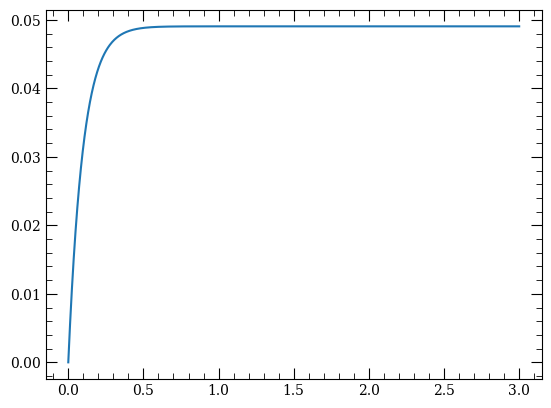

In [28]:
all_ground = np.zeros(4**2-1)
sol_norwa_ground = rq.solve_time(sensor_time_norwa, end_time, num_pts, init_cond=all_ground)
susc_norwa_ground = sol_norwa_ground.coupling_coefficient_observable()

fig, ax = plt.subplots()
ax.plot(sol_norwa_ground.t, susc_norwa_ground.imag)
plt.show()


This plot helps shed some light on the reason `rydiqule` makes the default choice it does. The transient ramp up is much bigger, and it is hard to see any oscillations in this plot. Depending on what you are modelling, it often makes sense to leave the inital condition alone, but it is useful to know you can change it. Let's chop off the first 340 points and see that the steady-state behavior is still similar:

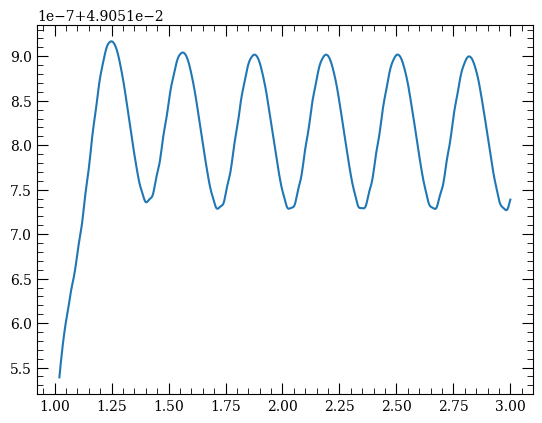

In [27]:
fig, ax = plt.subplots()
ax.plot(sol_norwa_ground.t[340:], susc_norwa_ground.imag[340:]);
plt.show()

### 3.3 Time Dependance with the RWA 
Now that we have shown time-dependence in the simplest case, with no rotating wave approximation, let us examine how we can still use the rotating wave approximation and still solve for time-domain behavior of the system. This is desirable in a number of cases, for example in a pulsed laser scheme.

Remember that if the RWA is valid for the system you are trying to model, it is generally a good idea to use it. `rydiqule` does note make any decisions regarding this for you, it is up to the physicist to decide in which situations it is a reasonable approximation of system behavior. In any time solver, modelling higher frequencies will be slower. Depending on how high your frequencies are, this can be many orders of magnitude. For this reason, modelling lasers fully in the time domain, for example is basically always a bad idea; you might be waiting an amount of time that is, practically speaking, forever.

Below we show a system that we define similarly to the previous example, the only exception being that the `(2,3)` coupling now is specified with a 1 Mrad/s detuning (the same detuning defined explicitly above), and show that the behavior is the same.

In [29]:
#101 Mrad/s field, modulated
def my_field_rwa(t):
    return np.sin(10*t)

sensor_time_rwa = rq.Sensor(4)
sensor_time_rwa.add_coupling((0,1), detuning=0, rabi_frequency=1)
sensor_time_rwa.add_coupling((1,2), detuning=0, rabi_frequency=2)
sensor_time_rwa.add_coupling((2,3), detuning=1, rabi_frequency=1, time_dependence=my_field_rwa)

sensor_time_rwa.add_transit_broadening(10)
sensor_time_rwa.add_decoherence((2,1), 1)
sensor_time_rwa.add_decoherence((3,2), 1)

print(sensor_time_rwa)

#1000 samples over 3 microsecond
end_time = 3
num_pts = 1000

sol_rwa = rq.solve_time(sensor_time_rwa, end_time, num_pts)

<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [0, 1, 2, 3]
Coherent Couplings: 
    (0,1): {rabi_frequency: 1, detuning: 0, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (0,1)}
    (1,2): {rabi_frequency: 2, detuning: 0, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (1,2)}
    (2,3): {rabi_frequency: 1, detuning: 1, phase: 0, kvec: (0, 0, 0), time_dependence: <function my_field_rwa at 0x76273838ede0>, coherent_cc: 1.0, label: (2,3)}
Decoherent Couplings:
    (0,0): {gamma_transit: 10.0}
    (1,0): {gamma_transit: 10.0}
    (2,0): {gamma_transit: 10.0}
    (2,1): {gamma: 1.0}
    (3,0): {gamma_transit: 10.0}
    (3,2): {gamma: 1.0}
Energy Shifts:
    None


Just like before, we will print the imaginary part of a unitless "susceptibility" against time, and see that indeed we get similar transient and quick steady-state behavior.

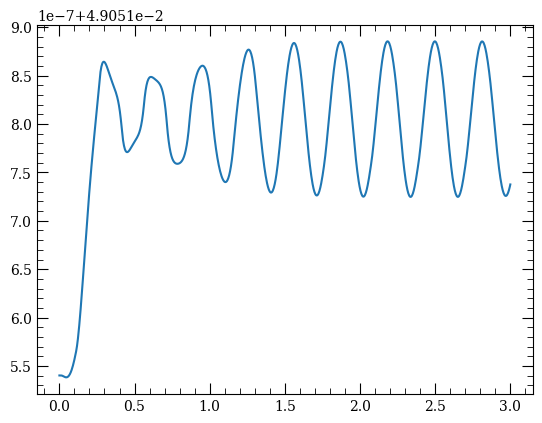

In [36]:
fig, ax = plt.subplots()
susc=sol_rwa.coupling_coefficient_observable()
ax.plot(sol_rwa.t, susc.imag);
plt.show()

There is an important caveat with regards to how to think about RWA couplings in the time domain. Remember that the approximation treats the field in the rotating frame of the *field*. In `rydiqule ` this applied field is implicitly assumed to be part of the coupling. This is how we keep specifications of couplings quick and easy. So in the above example, our 101 Mrad/s field is rotated into the 101 Mrad/s frame, with of 1 Mrad/s detuning from resonance (accounted for on the diagonal). As a result, the $\cos(101t)$ field becomes 1 as far as rydiqule is concerned, and we are left only with the modulating $\sin$ function and the manually specified detuning of 1 Mrad/s.

One should also note that there are some obvious numeric artifacts. Their origin and how to mitigate them is described in section 3.4.

#### Any python function works
Since `rydiqule` just calls the provided time function with no inference of its mathematical form, any python funtion will work; it need not be a sinusoid. This opens up options for things like stepwise functions. Lets reproduce the above RWA example, but rather than modulating the field by a sinusoid, we will use a pulsing function.

In [ ]:
# off from 0 to 1, on from 1 to 2, repeat 
def pulse_field(t):
    if 0 <= t%2 <= 1:
        return 0.0
    else:
        return 1.0

sensor_time_pulse = rq.Sensor(4)
sensor_time_pulse.add_coupling((0,1), detuning=0, rabi_frequency=1)
sensor_time_pulse.add_coupling((1,2), detuning=0, rabi_frequency=2)
sensor_time_pulse.add_coupling((2,3), detuning=1, rabi_frequency=1, time_dependence=pulse_field)

sensor_time_pulse.add_transit_broadening(10)
sensor_time_pulse.add_decoherence((2,1), 1)
sensor_time_pulse.add_decoherence((3,2), 1)

print(sensor_time_pulse)

#1000 samples over 1 microsecond
end_time = 10
num_pts = 1000

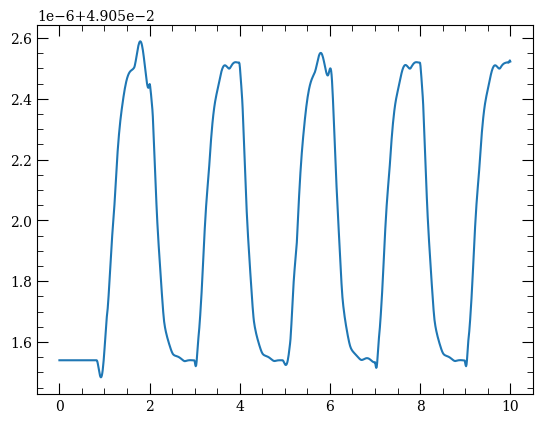

In [41]:
sol_pulse = rq.solve_time(sensor_time_pulse, end_time, num_pts)
susc_pulse = sol_pulse.coupling_coefficient_observable()

fig, ax = plt.subplots()
ax.plot(sol_pulse.t, susc_pulse.imag);
plt.show()

We did not leave enough time to enter a steady-state on any particular pulse (again, we are not trying to demonstrate meaningful physics in this notebook), but we can see that the solver ran fine, and the plusing behavior we would expect is present.

### 3.4 Multi-value Parameters in a time solve
Just like `solve_steady_state`, `solve_time` supports coupling parameter definitions that are list-like. It works more or less as you might expect based on the behavior of steady-state solving, but it is worth briefly discussing for the sake of demonstrating what the solution might look like.

We will start with a `Sensor` identical to the one in 3.3, but with the `(2,3)` transition's `rabi_frequency` and `detuning` defined as lists. Note that because we are scanning 2 parameters over 51 values, there are actually $51\times 51=2,601$ sets of equations being solved. `rydiqule` is pretty efficient, even in the time solver, for reasonable frequencies, but is not magical. This cell may take longer than previous ones (and probably spin up your computer fans a little), but it should be doable.

In [43]:
#101 Mrad/s field, modulated
def my_field_rwa(t):
    return np.sin(10*t)

dets = np.linspace(-5,5,51)
rabis = np.linspace(-1,1,51)

sensor_time_scan = rq.Sensor(4)
sensor_time_scan.add_coupling((0,1), detuning=0, rabi_frequency=1)
sensor_time_scan.add_coupling((1,2), detuning=0, rabi_frequency=2)
sensor_time_scan.add_coupling((2,3), detuning=dets, rabi_frequency=rabis, time_dependence=my_field_rwa)

sensor_time_scan.add_transit_broadening(10)
sensor_time_scan.add_decoherence((2,1), 1)
sensor_time_scan.add_decoherence((3,2), 1)

print(sensor_time_scan)

#1000 samples over 3 microsecond
end_time = 3
num_pts = 1000

sol_time_scan =  rq.solve_time(sensor_time_scan, end_time, num_pts, atol=1e-9)

susc_scan = sol_time_scan.coupling_coefficient_observable()

<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [0, 1, 2, 3]
Coherent Couplings: 
    (0,1): {rabi_frequency: 1, detuning: 0, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (0,1)}
    (1,2): {rabi_frequency: 2, detuning: 0, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (1,2)}
    (2,3): {rabi_frequency: <parameter with 51 values>, detuning: <parameter with 51 values>, phase: 0, kvec: (0, 0, 0), time_dependence: <function my_field_rwa at 0x762737805da0>, coherent_cc: 1.0, label: (2,3)}
Decoherent Couplings:
    (0,0): {gamma_transit: 10.0}
    (1,0): {gamma_transit: 10.0}
    (2,0): {gamma_transit: 10.0}
    (2,1): {gamma: 1.0}
    (3,0): {gamma_transit: 10.0}
    (3,2): {gamma: 1.0}
Energy Shifts:
    None


As a note, we tightened our absolute tolerance on the time solver. Why is somewhat beyond the scope of this notebook, but it is worth briefly explaining. Under the hood, `rydiqule` uses `scipy`'s `solve_ivp` function with a Runge-Kutta method of order 4(5). To make this work seamlessly with large stacks, `rydiqule` performs some reshape operations, and with such a large vector, the `"RK45"` hueristics will behave differently on an huge list of values as opposed to just the 15 in a single density matrix.

The details are not relevant here, but these sorts of numerical analyses are something `rydiqule` can only take so far, you ultimately need to judge whether a potential numerical error has occured. We made the above choice by analyzing what the plot looked like. As a general rule, if the plot is behaving unexpectedly, the `atol` can be set an order of magnitude or so smaller than any oscillations. You may have astutely noticed that the RWA and non RWA examples above did not match *exaclty*, and this was almost certainly the reason. However, we made the decision not to adjust since we caputred the relevant behavior just fine. Ultimately, `rydiqule` uses the `scipy` default of 1e-3, but you may need to adjust it to suit your problem, just like you would with any ivp solver. 

Anyhow, just as we did before, let us investigate some key parts of the `Solution` `sol_time_scan`:

In [44]:
print(sol_time_scan.rho.shape)
print(sol_time_scan.axis_labels)

(51, 51, 1000, 15)
['(2,3)_detuning', '(2,3)_rabi_frequency', 'time', 'density_matrix']


So we can see that the shape is as expected. The ordering of the time axes here is general -- in a `rydiqule` time soluion, axes will always be ordered as parameters, time, density matrix.

Just for fun, lets try and plot the solution, that corresponds to the single-value solve above, at `detuning=1` and `rabi_frequency=1`. We use `np.where()` to get the correct indeces. Note that we can still apply functions like observales to the solution without changing the indexing

In [ ]:
det_idx = np.where(dets==1)[0][0]
rabi_idx = np.where(rabis==1)[0][0] #the return typle of where is tuple(array), although there is only 1 index

time = sol_time_scan.t
print(susc_scan.shape)
susc_plot = susc_scan[30,50] #apply squeeze operatiob because indexing leaves 

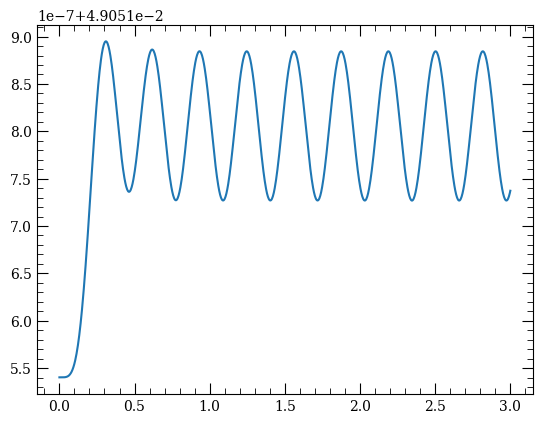

In [47]:
fig, ax = plt.subplots()
ax.plot(time, susc_plot.imag)
plt.show()

---
## 4. Simulating Doppler broadening
One final key piece of functionality in `rydiqule` is the ability to simulate a doppler-broadened system. Internally, this is handled by breaking a doppler velocity profile into some number of slices, then applying the corresponding detunings for each class to the unshifted solution. This produces many sets of equations of motion, which are then solved, and then a weighted average performed to get the doppler-broadened solution.

To set up a system with doppler broadening, we use the the `"kvec"` keyword the couplings definition along with the `vP` attribute. A `kvec` is a 3-element spatial vector corresponding to the usual definition of a k-vector for an electromagnetic plane wave, defined in units of Mrad/m. `Sensor.vP` is an attribute that defines the most probable speed for an atom in a given sensor assuming a 3-D Maxwell-Boltzmann velocity distribution. Note that when multiplied `vP` and `kvec` correspond to the most probable doppler shift vector with respect to a given laser in Mrad/s.

Configuring doppler settings can get involved, and much of the functionality surrounding doppler handling is beyond the scope of an introductory notebook. This will be a quick discussion, but should at least be useful in handling most simple cases. If applying the steps outlined here produces unexpected results, you can find more details about how `rydiqule` does doppler in the [physics](https://rydiqule.readthedocs.io/page/writeups/doppler.html) and [api](https://rydiqule.readthedocs.io/page/api/_autosummary/rydiqule.doppler_utils.html#module-rydiqule.doppler_utils) doppler documentation.

### 4.1 A simple doppler example.
Let us recreate the system in 2.4 above, which was the first thing we plotted. Recall that there was a large main peak, consisting of 3 sharp subpeaks. If we account for a small amount of doppler, broadening, we would expect those sharper features to be smeared out. In the example below we will apply doppler broadening to a pair of co-propagating lasers.

A doppler broadening of 1 MHz is wider than the narrow subpeaks but narrower than the main peak, so with that amount of broadening, the large peak should stay similar in width, but the small peaks will no longer be able to be resolved. Let us test this hypothesis as a quick smell-check that `rydiqule` is doing something reasonable with doppler broadening.

Recall that `kvec` is an attribute of a particular coupling, while `vP` is a property of sensor, and can be defined either in the constructor using `Sensor(....,vP=<value>)`, or after construction with `my_sensor.vP = <value>` 

In [14]:
basis_size = 4
sensor_doppler = rq.Sensor(basis_size, vP=2)

k_mag = np.pi #Mrad/m
k_direction = np.array([1,0,0])

detunings = 2*np.pi*np.linspace(-10,10,201) #201 values between -10 and 10 MHz
probe = {"states":(0,1), "detuning": detunings, "rabi_frequency": 3, 'kvec': k_direction*k_mag}
coupling = {"states":(1,2), "detuning": 0, "rabi_frequency": 5, 'kvec': k_direction*k_mag}
rf = {"states":(2,3), "detuning": 0, "rabi_frequency":7}

sensor_doppler.add_couplings(probe, coupling, rf)

gamma = np.zeros((basis_size, basis_size))
gamma[1:,0] = 0.1
sensor_doppler.set_gamma_matrix(gamma)

print(sensor_doppler)

<class 'rydiqule.sensor.Sensor'> object with 4 states and 3 coherent couplings.
States: [0, 1, 2, 3]
Coherent Couplings: 
    (0,1): {rabi_frequency: 3, detuning: <parameter with 201 values>, phase: 0, kvec: <parameter with 3 values>, coherent_cc: 1.0, label: (0,1)}
    (1,2): {rabi_frequency: 5, detuning: 0, phase: 0, kvec: <parameter with 3 values>, coherent_cc: 1.0, label: (1,2)}
    (2,3): {rabi_frequency: 7, detuning: 0, phase: 0, kvec: (0, 0, 0), coherent_cc: 1.0, label: (2,3)}
Decoherent Couplings:
    (1,0): {gamma: 0.1}
    (2,0): {gamma: 0.1}
    (3,0): {gamma: 0.1}
Energy Shifts:
    None


Before checking out the solution, Let us briefly touch on what is happening under the hood with a doppler solve. `rydiqule` leverages its existing stack framework internally by adding more hamiltonians to the stack. It will create and solve a set of Hamiltonians and equations for each doppler class. Then at the end, it will apply weights based on the population in each class assuming a Boltzmann distribution of velocity classes, and sum the weighted classes together. Note that the solution's final shape is the same as it would be without doppler. So the internals of dopper are, in basic cases, something you don't actually need to see. 

Note that since doppler is a parameter of the solve rather than an argument of `Sensor` itself, 

In [8]:
solution_doppler = rq.solve_steady_state(sensor_doppler, doppler=True)
print(f"Solution shape: {solution_doppler.rho.shape}")

Solution shape: (201, 15)


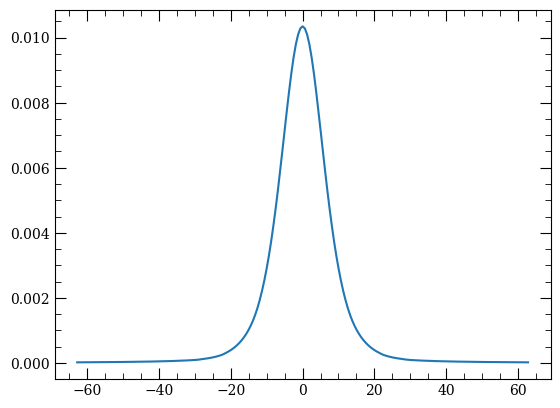

In [13]:
absorption_doppler = solution_doppler.coupling_coefficient_observable().imag
plt.plot(detunings, absorption_doppler)
plt.show()

Perfect, it is as we expected: The three narrow peaks comprising the larger one have been blurred into a single peak.

It is also worth mentioning that the same argument works identically in the `solve_time()` function.

### 4.2 A word of caution
Once you realize `rydiqule` can do doppler broadening, it may be tempting to apply it to all your experiments. It is important to keep in mind that for each axis over which you account for doppler broadening, you are increasing the number of equations to solve by a factor of $n_{classes}$, which by default is ~600. Remember, in its current iteration `rydiqule` explicitly solves every doppler class, it does not use any hueristics. Adding doppler broadening can quickly get out of control in both memory and computation time. A seemingly innocuous `kvec=k_mag*(1,1,1)` will apply doppler broadening in 3 dimensions and increase the number of equations `rydiqule` solves by a factor of 8,000,000. This is not to tell you not to use doppler, just to understand what you are asking `rydiqule` to do. 

---
## 5. What Next?
Hopefully, you now have a good idea of the basics of how `rydiqule` can be used to solve atomic systems in a variety of ways. Depending what you want to do, you can start running your own simulations. 

If you intend to simulate real-world lab experiments with actual Rydberg atoms, the `rydiqule.Cell` module has tools to do exaclty that. It inherits from `Sensor`, so all the basic priciples apply, but some funcitonality has been added to calulate things like dipole moments, decay rates, and state energies automatically using functionality from the `ARC` package. We have a `Cell_Basics.ipynb` notebook in the same folder as this one, and you now equipped to go through that tutorial. That notebook *will* assume that you understand the principles of this one, but it provides useful tools to start simulating your own Rubidium. After that, the rest of the examples in this notebook show examples using `Cell` to simulate real experiments that you could do in a lab.